In [1]:
%matplotlib inline

In [2]:
import yaml
import sys
import traceback
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from typing import *
from torch import multiprocessing as mp
from multiprocessing.pool import Pool
from multiprocessing import Queue, Manager

In [3]:
%load_ext autoreload
%autoreload 2

import os
current_dir = os.getcwd()
os.chdir("../src")
from dqnroute import *
os.chdir(current_dir)

In [4]:
logger = logging.getLogger(DQNROUTE_LOGGER)
TORCH_MODELS_DIR = '../torch_models'
LOG_DATA_DIR = '../logs/runs'

np.set_printoptions(linewidth=500)

In [5]:
_legend_txt_replace = {
    'networks': {
    'link_state': 'Shortest paths',
    'simple_q': 'Q-routing',
    'pred_q': 'PQ-routing',
    'glob_dyn': 'Global-dynamic',
    'dqn': 'DQN',
    'dqn_oneout': 'DQN (1-out)',
    'dqn_emb': 'DQN-LE',
    'centralized_simple': 'Centralized control'
    },
    'conveyors': {
    'link_state': 'Vyatkin-Black',
    'simple_q': 'Q-routing',
    'pred_q': 'PQ-routing',
    'glob_dyn': 'Global-dynamic',
    'dqn': 'DQN',
    'dqn_oneout': 'DQN (1-out)',
    'dqn_emb': 'DQN-LE',
    'centralized_simple': 'BSR'
    }
}

_targets = {'time': 'avg','energy': 'sum', 'collisions': 'sum'}

_ylabels = {
    'time': 'Mean delivery time',
    'energy': 'Total energy consumption',
    'collisions': 'Cargo collisions'
}

def print_sums(df):
    types = set(df['router_type'])
    for tp in types:
        x = df.loc[df['router_type']==tp, 'count'].sum()
        txt = _legend_txt_replace.get(tp, tp)
        print('  {}: {}'.format(txt, x))

def plot_data(data, meaning='time', figsize=(15,5), xlim=None, ylim=None,
              xlabel='Simulation time', ylabel=None,
              font_size=14, title=None, save_path=None,
              draw_collisions=False, context='networks', **kwargs):
    if 'time' not in data.columns:
        datas = split_dataframe(data, preserved_cols=['router_type', 'seed'])
        good_time = None
        for tag, df in datas:
            if tag == 'collisions' and not draw_collisions:
                print('Number of collisions:')
                print_sums(df)
                continue
                
            xlim = kwargs.get(tag+'_xlim', xlim)
            ylim = kwargs.get(tag+'_ylim', ylim)
            save_path = kwargs.get(tag+'_save_path', save_path)
            plot_data(df, meaning=tag, figsize=figsize, xlim=xlim, ylim=ylim,
                      xlabel=xlabel, ylabel=ylabel, font_size=font_size,
                      title=title, save_path=save_path, context='conveyors')
        return 
    
    target = _targets[meaning]
    if ylabel is None:
        ylabel = _ylabels[meaning]
        
    fig = plt.figure(figsize=figsize)
    ax = sns.lineplot(x='time', y=target, hue='router_type', data=data,
                      err_kws={'alpha': 0.1})
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = list(map(lambda l: _legend_txt_replace[context].get(l, l), labels[1:]))
    ax.legend(handles=handles[1:], labels=new_labels, fontsize=font_size)
    
    ax.tick_params(axis='both', which='both', labelsize=int(font_size*0.75))
        
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    
    plt.show(fig)
    
    if save_path is not None:
        fig.savefig('../img/' + save_path, bbox_inches='tight')

def split_data(dct):
    results = []
    
    def add_res(i, key, val):
        while len(results) <= i:
            results.append({})
        results[i][key] = val
    
    for (key, vals) in dct.items():
        for (i, val) in enumerate(vals):
            add_res(i, key, val)
    return tuple(results)
    
def combine_launch_data(launch_data):
    dfs = []
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        df = data.copy()
        add_cols(df, router_type=router_type, seed=seed)
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [6]:
class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

In [7]:
def run_network_scenario_file(file: str, **kwargs):
    """
    Helper wrapper around `NetworkEnvironment` which should run in a separate thread.
    """        
    return run_simulation(NetworkRunner, run_params=file, **kwargs)

def run_conveyor_scenario_file(file: str, **kwargs):
    """
    Helper wrapper around `ConveyorsEnvironment` which should run in a separate thread.
    """
    return run_simulation(ConveyorsRunner, run_params=file, **kwargs)

def run_single(func, router_type: str, random_seed: int, **kwargs):
    job_id = mk_job_id(router_type, random_seed)
    with tqdm(desc=job_id) as bar:
        queue = DummyProgressbarQueue(bar)
        results = func(router_type=router_type, random_seed=random_seed,
                       progress_queue=queue, **kwargs) 
     
    if type(results) is tuple:
        for df in results:
            add_cols(df, router_type=router_type, seed=random_seed)
    else:
        add_cols(results, router_type=router_type, seed=random_seed)
    return results

def exc_print(e):
    print(''.join(traceback.format_exception(etype=type(e), value=e, tb=e.__traceback__)))

def run_threaded(func, router_types: List[str], random_seeds: List[int],
                 ignore_saved: Union[bool, List[str]] = [], *args, **kwargs):
    """
    Runs several scenario runners in multiple threads and displays progress bars for them
    """

    pool = Pool()
    m = Manager()
    queue = m.Queue()
    jobs = {}
    bars = {}
    if ignore_saved == True:
        ignore_saved = router_types
    
    for router_type in router_types:
        for seed in random_seeds:
            job_id = mk_job_id(router_type, seed)
            job_args = dict(kwargs, router_type=router_type, random_seed=seed,
                            ignore_saved=router_type in ignore_saved, progress_queue=queue)
            jobs[job_id] = pool.apply_async(func, args=args, kwds=job_args,
                                            error_callback=exc_print)
            bars[job_id] = tqdm(desc=job_id)

    while len(bars) > 0:
        (job_id, val) = queue.get()
        if val is None:
            bars.pop(job_id).close()
        else:
            bars[job_id].update(val)
        
    results = {job_id: job.get() for (job_id, job) in jobs.items()}
    pool.close()
    return combine_launch_data(results)

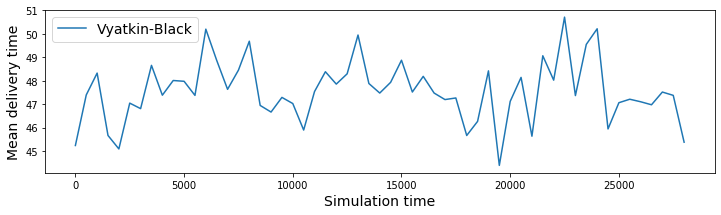

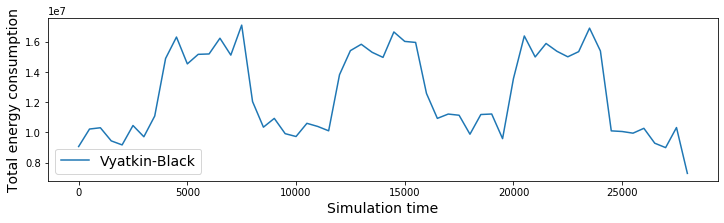

Number of collisions:
  link_state: 0.0


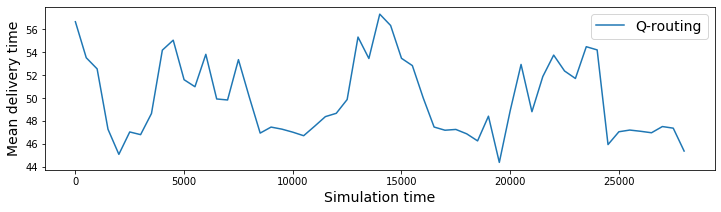

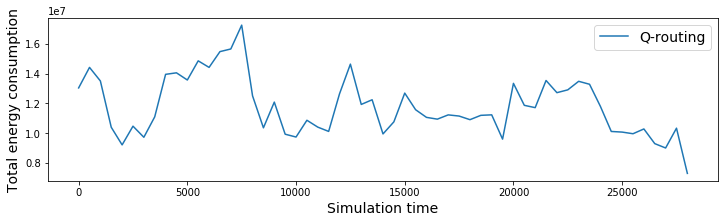

Number of collisions:
  simple_q: 0.0


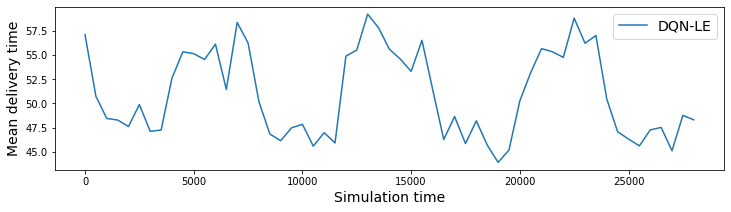

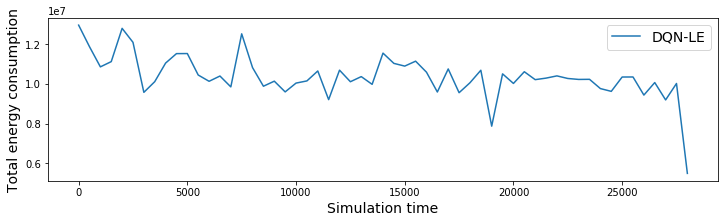

Number of collisions:
  dqn_emb: 0.0


In [9]:
file = '../launches/conveyor_energy_test.yaml'
for algo in ['link_state', 'simple_q', 'dqn_emb']: #, 'dqn']:
    launch6_data = run_single(run_conveyor_scenario_file, random_seed=42,#[42, 43, 44],
                                file=file, router_type=algo, ignore_saved=True, progress_step=500)
    plot_data(launch6_data, figsize=(12,3))

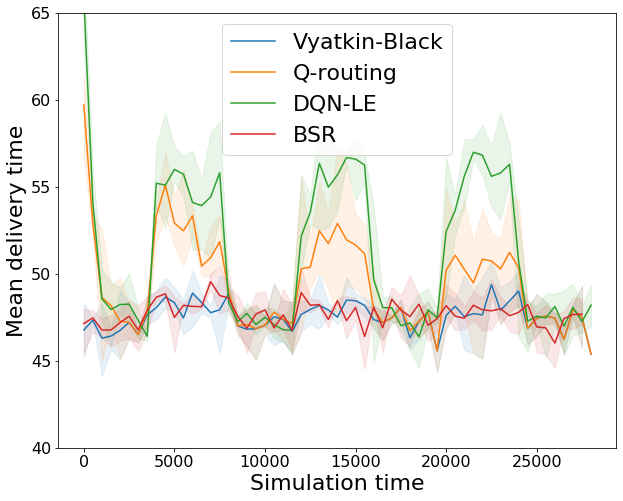

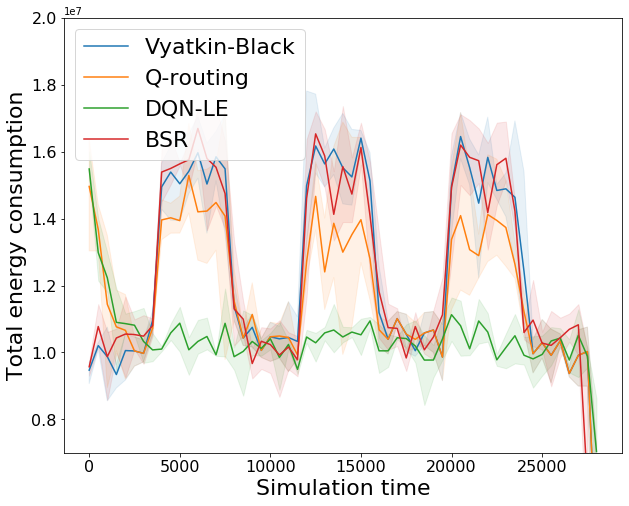

Number of collisions:
  dqn_emb: 0.0
  simple_q: 0.0
  link_state: 0.0
  centralized_simple: 0.0


In [61]:
# '../launches/conveyor_energy_test.yaml'

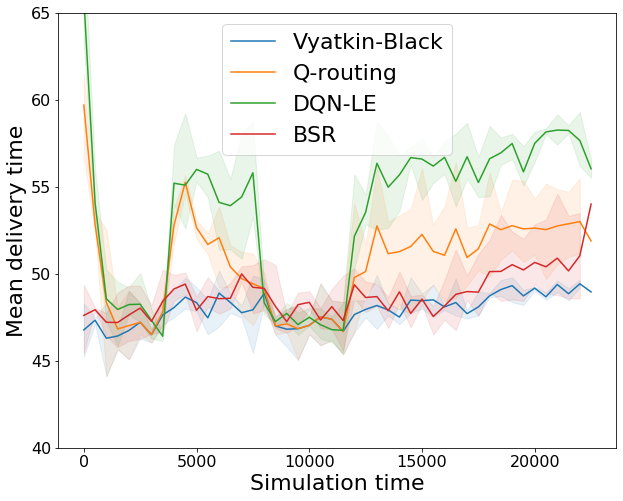

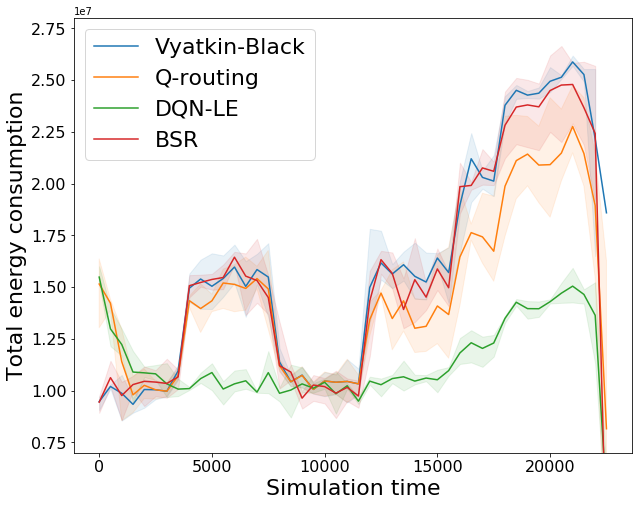

Number of collisions:
  dqn_emb: 0.0
  simple_q: 3.0
  link_state: 5.0
  centralized_simple: 0.0


In [62]:
# '../launches/conveyor_energy_test_2.yaml'

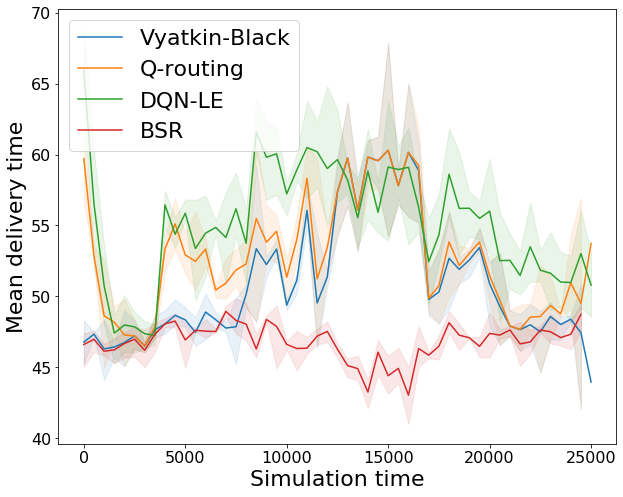

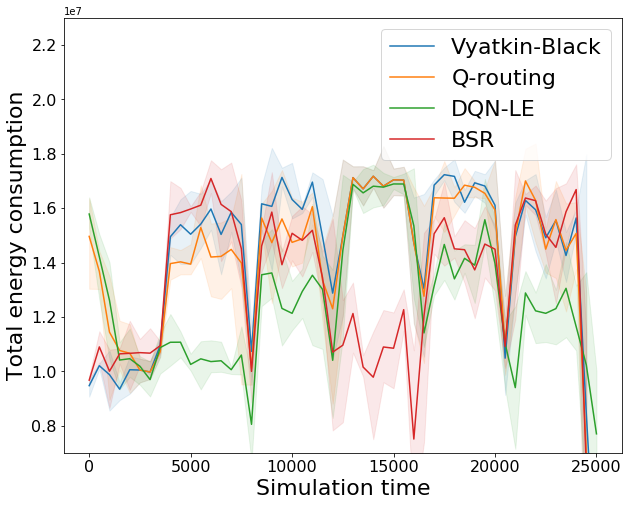

Number of collisions:
  dqn_emb: 0.0
  simple_q: 68.0
  link_state: 0.0
  centralized_simple: 460.0


In [63]:
# '../launches/conveyor_break_test.yaml'

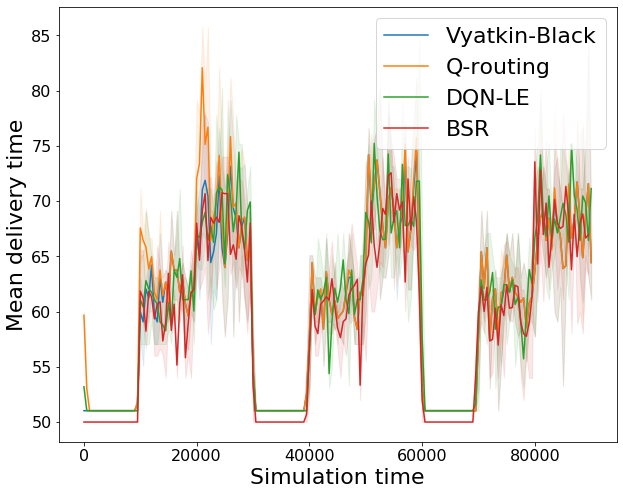

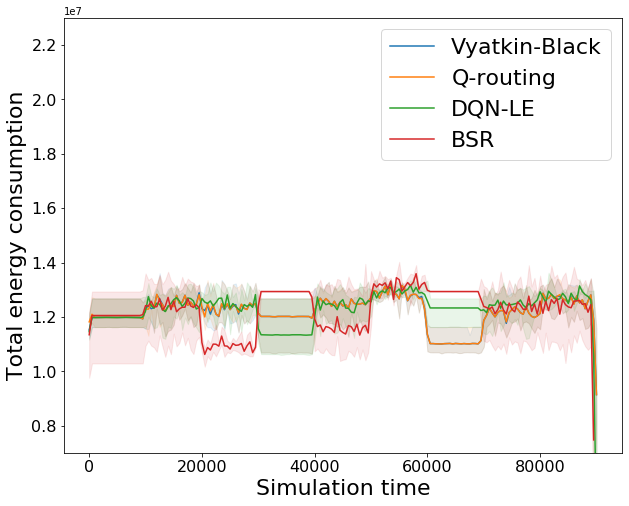

Number of collisions:
  dqn_emb: 0.0
  simple_q: 0.0
  link_state: 0.0
  centralized_simple: 0.0


In [65]:
# '../launches/conveyor_whatevs_test.yaml'